#  Mount google drive, install dependencies and import required packages

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd '/content/drive/My Drive/Transformer/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
/content/drive/My Drive/Transformer


In [2]:
# Install transformers
!pip install transformers

     |████████████████████████████████| 675kB 2.8MB/s 
     |████████████████████████████████| 3.8MB 13.6MB/s 
     |████████████████████████████████| 890kB 27.8MB/s 
     |████████████████████████████████| 1.1MB 47.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=c8b605ed1300981b2231b31d21212197de614453d3b76d61ae973a51c24ab8ec
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [0]:
import torch
import torch.optim as optim
import os.path
from os import path
import matplotlib.pyplot as plt
from torch.utils import data
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from src import utils
from transformers import T5Tokenizer, T5ForConditionalGeneration

model_path = "models/checkpoint.pth"

# Retrieve training and validation data from google drive

In [0]:
X_train,Y_train = [],[]  
file=open("train/train.token.sbt")
for line in file:
  X_train.append(line)
file=open("train/train.token.nl")
for line in file:
  Y_train.append(line)
l=int(len(X_train)/3)
X_train = X_train[0:l]
Y_train = Y_train[0:l]

In [0]:
X_valid,Y_valid = [],[]
file=open("val/valid.token.sbt")
for line in file:
  X_valid.append(line)
file=open("val/valid.token.nl")
for line in file:
  Y_valid.append(line)
l=int(len(X_valid)/3)
X_valid = X_valid[0:l]
Y_valid = Y_valid[0:l]

# Dataset Class to load data while training and validation

In [0]:
class Dataset(data.Dataset):
  def __init__(self, X_item, Y_item):
    self.X_item=X_item
    self.Y_item=Y_item

  def __len__(self):
    return len(self.X_item)

  def __getitem__(self, index):
    X = self.X_item[index]
    
    Y = self.Y_item[index]
    return X, Y

# Take GPU into action and define batch size and num of workers

In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(">>> ", device)
params = {'batch_size': 4,
          'shuffle': True,
          'num_workers': 2}

training_set = Dataset(X_train,Y_train)
training_generator = data.DataLoader(training_set, **params)

validation_set = Dataset(X_valid,Y_valid)
validation_generator = data.DataLoader(validation_set, **params)

num_epoch = 20

>>>  cuda


## Load tokenizer

In [8]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')
trainloss=0
validloss=0

## Load model, optimizer, trainer, epoch no. and losses from a checkpoint directly or from the saved location.

In [9]:
#load pre-trained model
model = T5ForConditionalGeneration.from_pretrained('t5-small')
model = model.to(device)

#load opptimizer
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_grouped_parameters = []
lr=2e-5
for key, value in dict(model.named_parameters()).items():
    if value.requires_grad:
        if any(nd in key for nd in no_decay):
            optimizer_grouped_parameters += [
                {"params": [value], "lr": lr, "weight_decay": 0.01}
            ]
        if not any(nd in key for nd in no_decay):
            optimizer_grouped_parameters += [
                {"params": [value], "lr": lr, "weight_decay": 0.0}
            ]
                
optimizer = utils.BertAdam(
            optimizer_grouped_parameters,
            lr=lr,
            warmup=0.1,
            t_total=100,
            schedule='warmup_constant',
        )
loss_train = []
loss_valid = []
epoch = 0

In [10]:
if path.exists(model_path):

  #load saved model from the drive
  checkpoint = torch.load(model_path)
  epoch = checkpoint['epoch']
  model.load_state_dict(checkpoint["state_dict"])
  optimizer.load_state_dict(checkpoint['optimizer'])
  loss_train = checkpoint['trainloss']
  loss_valid = checkpoint['validloss']
  print(">>> loaded saved checkpoint from epoch ", epoch)
  print(">>> Saved model ")
  model.eval()
  model = model.to(device)

else:
  print(">>> loaded from pre-trained model ")

>>> loaded from pre-trained model 


## Plot train and valid loss to see the curve

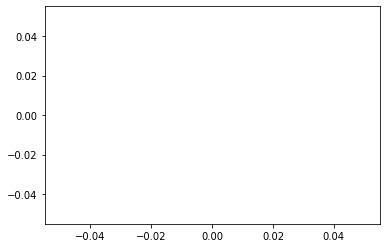

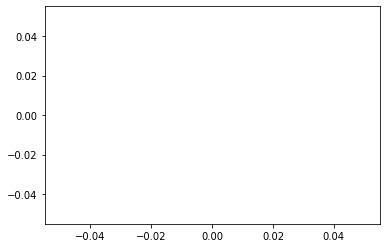

In [11]:
plt.plot(loss_train)
plt.show()
plt.plot(loss_valid)
plt.show()

# Training and validation loop

In [0]:
while epoch < num_epoch:

  trainloss = 0
  validloss = 0  
  print("Running EPOCH : ", epoch)
  """Training"""
  for local_batch, local_labels in tqdm(training_generator): 
    model.zero_grad()
    """Forward Function Implementation"""
    input_ids = tokenizer.batch_encode_plus(local_batch, return_tensors="pt",pad_to_max_length=True)
    label = tokenizer.batch_encode_plus(local_labels, return_tensors="pt",pad_to_max_length=True)
    outputs = model(input_ids=(input_ids['input_ids']).to(device), lm_labels=(label['input_ids']).to(device),attention_mask=(input_ids['attention_mask']).to(device))
    trainloss = outputs[0]
    """Forward Function Ends here"""
    """Loss and optimizer"""
    trainloss.backward()
    optimizer.step()
  
  loss_train.append(trainloss)

  """Validation"""
  with torch.set_grad_enabled(False):
    for local_batch, local_labels in tqdm(validation_generator):
      input_ids = tokenizer.batch_encode_plus(local_batch, return_tensors="pt",pad_to_max_length=True)
      label = tokenizer.batch_encode_plus(local_labels, return_tensors="pt",pad_to_max_length=True)
      model.eval()
      outputs = model(input_ids=(input_ids['input_ids']).to(device), lm_labels=(label['input_ids']).to(device))
      validloss += outputs[0]
  validloss = validloss / len(validation_generator)
  loss_valid.append(validloss)
  print("\nEpoch ", epoch, " completed! \nTrain loss is: ", trainloss, "\nValid loss is: ", validloss)
  
  """Save states"""
  states = {
          'epoch': epoch + 1,
          'state_dict': model.state_dict(),
          'optimizer': optimizer.state_dict(),
          'trainloss': loss_train,
          'validloss': loss_valid
      }
  torch.save(states, model_path)

  epoch += 1

Running EPOCH :  0


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


## Load Test Data

In [0]:
X_test,Y_test = [],[]
file=open("test/test.token.sbt")
for line in file:
  X_test.append(line)
file=open("test/test.token.nl")
for line in file:
  Y_test.append(line)
  
# Data loader for test set
test_set = Dataset(X_test[0:1000],Y_test[0:1000])
test_generator = data.DataLoader(test_set, **params)

## Calculate test set loss

In [0]:
import numpy as np
testloss = []

refs_list = []
hyp_list = []


with torch.set_grad_enabled(False):
  for local_batch, local_labels in tqdm(test_generator):
    input_ids = tokenizer.batch_encode_plus(local_batch, return_tensors="pt",pad_to_max_length=True)
    
    predY = model.generate(input_ids=(input_ids['input_ids']).to(device))
    
    for i,j in zip(predY, local_labels):
      hyp_list.append(tokenizer.decode(i))
      refs_list.append(j)
    # for i in local_labels:

    # print(np.shape(local_labels))
    # print(local_labels)
    #prediction = predY.transpose(0, 1).contiguous().data.cpu().tolist()[0] 
    #print(type(predY))
    #prediction=[]
# print("predict: ", hyp_list[0], "\n target: ", refs_list[0])
# testloss = testloss / len(test_generator)
# print("Test Loss: ", testloss)

In [0]:
print("predict: ", hyp_list[0], "       target: ", refs_list[0])

# Calculate Precision and Recall

In [0]:
precision, recall, f1 = utils.calculate_results(refs_list, hyp_list)
print(precision)
print(recall)
print(f1)